# Quick-start with the MNIST digits dataset

This tutorial covers a quick-start with `TopOMetry` using the MNIST handwritten digits dataset. This dataset is composed of ~1,800 handwritten digits images composed of 64 (8 x 8) pixels each. Our task will be to represent this high-dimensional space (of 64 dimensions) into a latent orthonormal eigenbasis. From this eigenbasis we will learn a new topological graph and visualize it with graph-layout algorithms. Although there are extensive options within `TopOMetry`, most people are interested in learning similarities, orthonormal eigenbases and graphs and graph-layouts associated with such eigenbases. In this tutorial, we'll see how to do so with the most robust `TopOMetry` algorithm: multiscale diffusion maps, which covers nearly all use-cases.

    
First, we'll load some libraries:

In [1]:
# Load some libraries:
import numpy as np
import topo as tp

# Import the MNIST data set:
from sklearn.datasets import load_digits
from scipy.sparse import csr_matrix

# Matplotlib for plotting:
from matplotlib import pyplot as plt
%matplotlib inline

Load the MNIST handwritten digits dataset from scikit-learn:

In [2]:
# # Load the digits data and the labels:
X, labels = load_digits(return_X_y=True)

### Set and fit a TopOGraph object

Then, we'll create an empty TopOGraph object to perform our analyses. The TopOGraph class is the main class used in TopOMetry to coordinate analyses between the multiple other classes available in the library. 
 

The TopOGraph can learn similarities, latent orthonormal eigenbases and new topological graphs from these eigenbases using various kernels and eigenmap strategies. By default, it uses an adaptive bandwidth kernel to learn a reweighted diffusion operator and and multiscale diffusion maps - this strategy is guaranteed to approximate the Laplace-Beltrami Operator (LBO) regardless of data geometry and sampling distribution. 

Because we already know we have 10 classes, we'll use a slightly larger number of components (`n_eigs`) to account for possible digits images which may be odd looking (e.g. 8's that look like 3's or 1's). If we hadn't known it beforehand, we could use larger numbers and try to select a number of components to keep by visualizing an eigengap. We could also try to use Fischer Separability Analysis (FSA) to estimate the global dimensionality of the data, which is also included in TopOMetry.

In [3]:
# Set up a TopOGraph object:
tg = tp.TopOGraph(n_eigs=15, n_jobs=-1, verbosity=0)

tg.fit(X)

TopOGraph object with 1797 samples and 64 observations and:
 . Base Kernels: 
    bw_adaptive - .BaseKernelDict['bw_adaptive']
 . Eigenbases: 
    DM with bw_adaptive - .EigenbasisDict['DM with bw_adaptive']
 . Graph Kernels:
 . Projections: 
 Active base kernel  -  .base_kernel 
 Active eigenbasis  -  .eigenbasis 
 Active graph kernel  -  .graph_kernel

The `fit()` method in the `TopOGraph` class learns a similarity kernel (referred to as 'base kernel') which will be used to compute an eigenbasis. A new kernel (referred to as 'graph kernel') will be used to learn topological affinities from this eigenbasis, which can be used for clustering and graph-layout optimization.

Let's visualize the eigenspectrum of our multiscale diffusion maps:

In [4]:
tg.eigenbasis.eigenvectors.shape

(1797, 15)

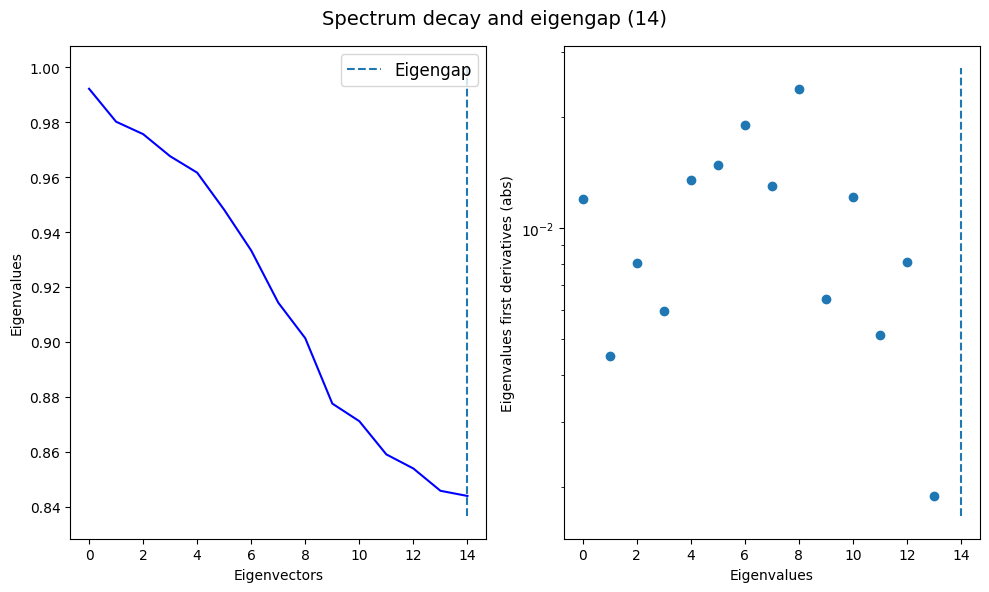

In [5]:
tg.eigenspectrum(figsize = (10, 6))

Let's inspect our eigenbasis class:

In [6]:
tg.eigenbasis

EigenDecomposition() estimator fitted with 1797 samples using Diffusion Maps, weighted by the square root of the eigenvalues.

The `EigenDecomposition` class returns its results with the `transform()` method. All computations are performed during `fit()`.

In [7]:
diffusion_maps = tg.eigenbasis.results()
diffusion_maps.shape

(1797, 15)

Let's visualize the multiscale diffusion maps results:

Text(0.5, 1.0, 'Multiscale Diffusion Maps projection of the Digits dataset')

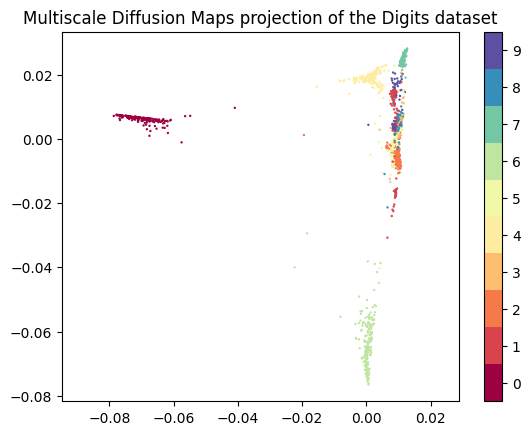

In [8]:
plt.scatter(diffusion_maps[:, 0], diffusion_maps[:, 1], c=labels, cmap='Spectral', s=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Multiscale Diffusion Maps projection of the Digits dataset', fontsize=12)

As we see, the diffusion maps do a decent job in separating major classes. However, this is not so great for visualization because each diffusion component will carry information regarding different classes:

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca_Y = pca.fit_transform(X)

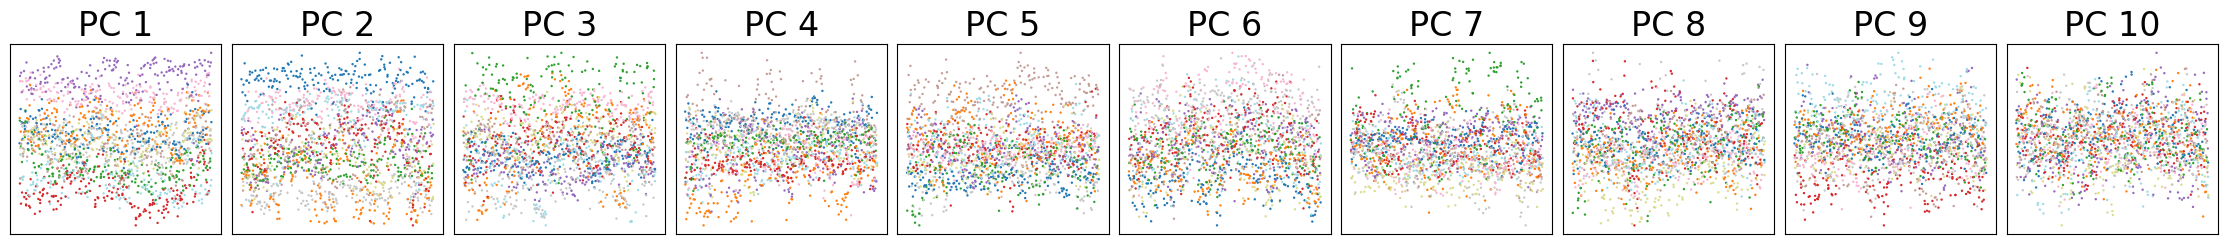

In [10]:
tp.pl.plot_eigenvectors(pca_Y, n_eigenvectors=10, labels=labels, s=0.5, title='PC', fontsize=24)

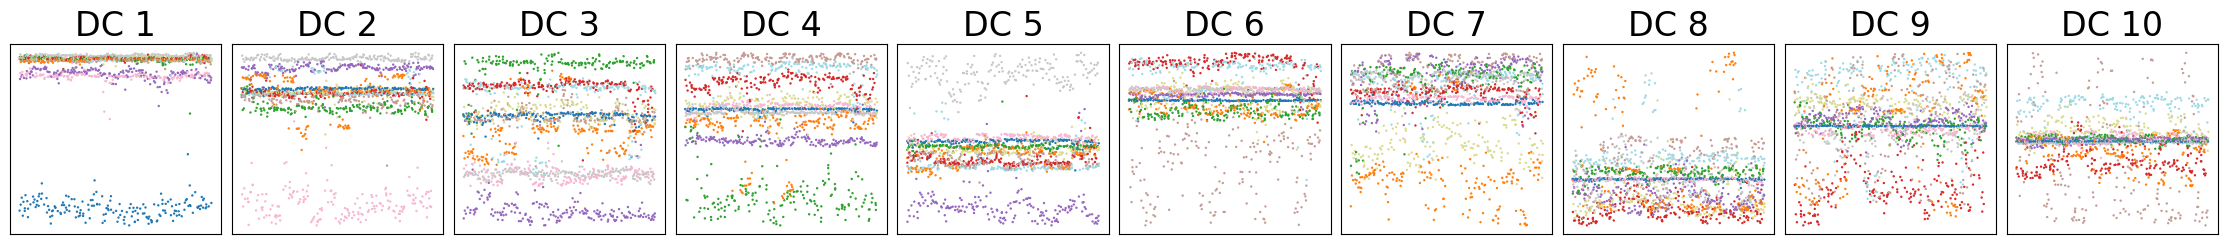

In [11]:
tp.pl.plot_eigenvectors(diffusion_maps, n_eigenvectors=10, labels=labels, s=0.5, title='DC', fontsize=24)

Therefore, ideally we should try to encode the information retrieved by several components into a single visualization to get a better understanding of this data. 

That's why we'll learn a new affinity graph and use it for visualization and clustering! This is done with the `transform()` method.

NOTE: You may have noticed the oscilatory pattern here. This is no coincidence. The eigenvectors of the Laplace-Beltrami Operator, like the eigenvectors of the graph Laplacian, form a basis for the space of functions defined on the manifold. This basis is similar to a Fourier basis in that it decomposes functions into a sum of sinusoidal functions with different frequencies. This makes them particularly useful for tasks such as spectral clustering or dimensionality reduction, where the structure of the data (i.e., the functions to be decomposed) is not known a priori.

In [12]:
tg.transform(X)
tg

TopOGraph object with 1797 samples and 64 observations and:
 . Base Kernels: 
    bw_adaptive - .BaseKernelDict['bw_adaptive']
 . Eigenbases: 
    DM with bw_adaptive - .EigenbasisDict['DM with bw_adaptive']
 . Graph Kernels: 
    bw_adaptive from DM with bw_adaptive - .GraphKernelDict['bw_adaptive from DM with bw_adaptive']
 . Projections: 
 Active base kernel  -  .base_kernel 
 Active eigenbasis  -  .eigenbasis 
 Active graph kernel  -  .graph_kernel

The graph kernel object is acessible at `TopOGraph.graph_kernel`. By default, TopOMetry uses its diffusion operator for visualization:

We can see this diffusion operator encodes the main 10 digits classes present in the data, with some uncertaintiny between similar classes:

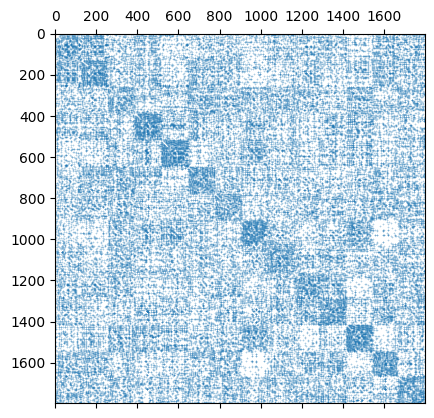

In [13]:
plt.spy(tg.graph_kernel.P, markersize=0.1)

### Project the results with a graph-layout method

Now let's visualize this graph! FOr visualization, we''ll use the `project()` method in `TopOGraph`. It takes as arguments the number of components, the method to be use for graph projection, an optional initialization and other keyword arguments.

For visualization, we'll use two methods that come with TopOMetry without need to install further libraries:
* ['Isomap'](https://doi.org/10.1126/science.290.5500.2319) - one of the very first manifold learning methods (it can be quite slow). Isomap preserves geodesics distances, being called a 'global' method.

* 'MAP'- a lighter [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) with slightly looser assumptions (in essence just the cross-entropy optimization). MAP / UMAP preserve neighborhood relationships with a focus on local neighborhoods, being called a 'local' method.

Text(0.5, 1.0, 'Isomap projection of diffusion operator on Multiscale DM of the Digits dataset')

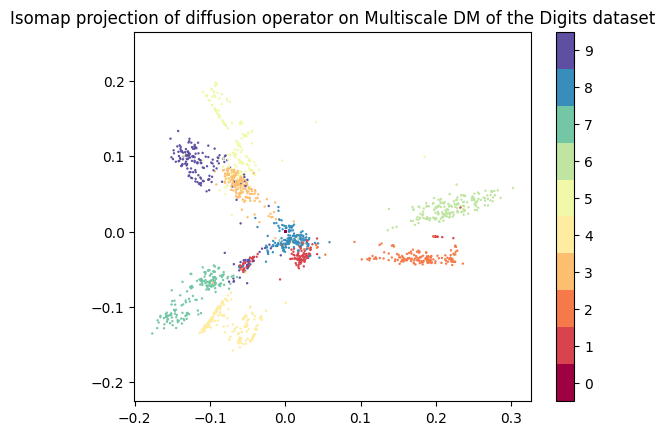

In [14]:
isomap = tg.project(projection_method='Isomap')

plt.scatter(isomap[:, 0], isomap[:, 1], c=labels, cmap='Spectral', s=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Isomap projection of diffusion operator on Multiscale DM of the Digits dataset', fontsize=12)

In [15]:
tg.ProjectionDict.keys()

dict_keys(['Isomap of bw_adaptive from DM with bw_adaptive'])

Text(0.5, 1.0, 'Kernel: bandwidth adaptive. Eigenbasis: diffusion maps. Projector: MAP')

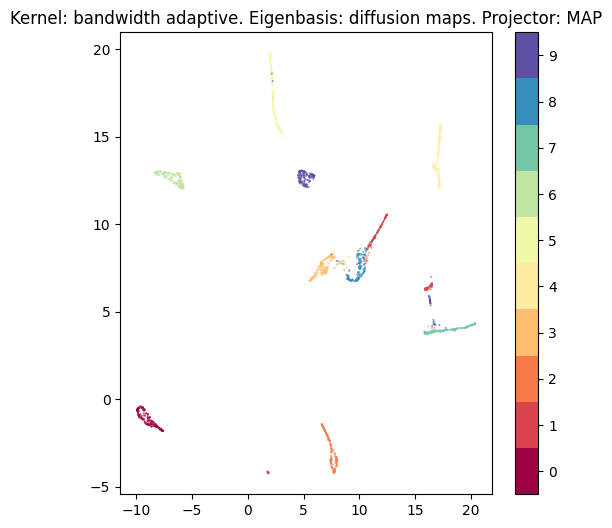

In [16]:
map = tg.project(projection_method='MAP')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(map[:, 0], map[:, 1], c=labels, cmap='Spectral', s=0.1)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Kernel: bandwidth adaptive. Eigenbasis: diffusion maps. Projector: MAP', fontsize=12)

### Use additional graph-layout methods

Other layout options are also available, but require installing other packages that are not listed as hard-dependencies:
* ['UMAP'](https://umap-learn.readthedocs.io/en/latest/index.html) - arguably the state-of-the-art for graph layout optimization (requires installing `umap-learn`)
* ['PaCMAP'](http://jmlr.org/papers/v22/20-1061.html) (Pairwise-controlled Manifold Approximation and Projection) - for balanced visualizations (requires installing `pacmap`)
* ['TriMAP'](https://github.com/eamid/trimap) - dimensionality reduction using triplets (requires installing `trimap`)
* 'IsomorphicMDE' - [MDE](https://github.com/cvxgrp/pymde) with preservation of nearest neighbors (requires installing `pymde`)
* 'IsometricMDE' - [MDE](https://github.com/cvxgrp/pymde) with preservation of pairwise distances (requires installing `pymde`)
* ['NCVis'](https://github.com/stat-ml/ncvis) (Noise Contrastive Visualization) - a UMAP-like method with blazing fast performance (requires installing `ncvis`)

Let's use PaCMAP for this example:

In [17]:
%pip install pacmap

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


PaCMAP has its own graph-learning algorithm, so instead of using the diffusion operator we learned from the multiscale diffusion maps,  TopOMetry automatically feeds it the diffusion maps itself.

Text(0.5, 1.0, 'PaCMAP projection of Multiscale DM of the Digits dataset')

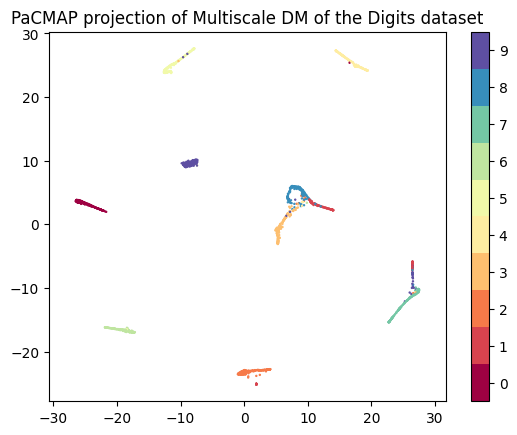

In [18]:
pacmap = tg.project(projection_method='PaCMAP')

plt.scatter(pacmap[:, 0], pacmap[:, 1], c=labels, cmap='Spectral', s=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('PaCMAP projection of Multiscale DM of the Digits dataset', fontsize=12)

### Condensing analysis into a single line of code

The `TopOGraph` class has the utility function `TopOGraph.run_models()` to run any given combinations of kernels, eigendecomposition strategies and projection methods. With it, you can perform all the analysis we have shown so far with a single line of code that populates TopOMetry slots. It takes as input a array-like dataset and the specified options:

HINT: You may want to change the verbosity parameter of your TopOGraph object before running all models - it can get quite verborrhagic.

In [19]:
# The default options:
tg.run_models(X, kernels=['bw_adaptive'],
                   eigenmap_methods=['msDM', 'DM', 'LE'],
                   projections=['MAP'])

As we can see, our `TopOGraph` is now populated with all the desired results:

In [20]:
tg

TopOGraph object with 1797 samples and 64 observations and:
 . Base Kernels: 
    bw_adaptive - .BaseKernelDict['bw_adaptive']
 . Eigenbases: 
    DM with bw_adaptive - .EigenbasisDict['DM with bw_adaptive'] 
    msDM with bw_adaptive - .EigenbasisDict['msDM with bw_adaptive'] 
    LE with bw_adaptive - .EigenbasisDict['LE with bw_adaptive']
 . Graph Kernels: 
    bw_adaptive from DM with bw_adaptive - .GraphKernelDict['bw_adaptive from DM with bw_adaptive'] 
    bw_adaptive from msDM with bw_adaptive - .GraphKernelDict['bw_adaptive from msDM with bw_adaptive'] 
    bw_adaptive from LE with bw_adaptive - .GraphKernelDict['bw_adaptive from LE with bw_adaptive']
 . Projections: 
    Isomap of bw_adaptive from DM with bw_adaptive - .ProjectionDict['Isomap of bw_adaptive from DM with bw_adaptive'] 
    MAP of bw_adaptive from DM with bw_adaptive - .ProjectionDict['MAP of bw_adaptive from DM with bw_adaptive'] 
    PaCMAP of DM with bw_adaptive - .ProjectionDict['PaCMAP of DM with bw_adapti

We may want to plot one of the learned projections:

Text(0.5, 1.0, 'A projection of the Digits dataset using TopOMetry')

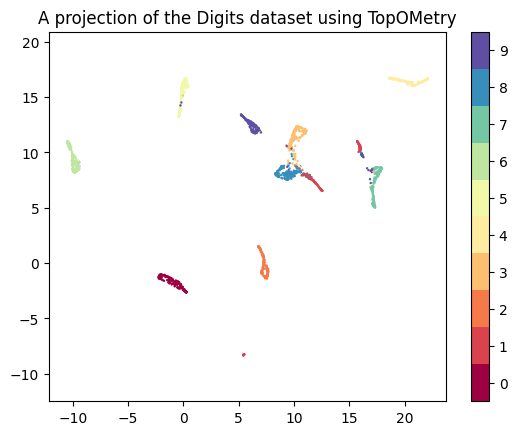

In [21]:
map_fuzzy_le = tg.ProjectionDict['MAP of bw_adaptive from LE with bw_adaptive']

plt.scatter(map_fuzzy_le[:, 0], map_fuzzy_le[:, 1], c=labels, cmap='Spectral', s=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('A projection of the Digits dataset using TopOMetry', fontsize=12)

This is it for this first tutorial! To check how to use the `Kernel`, `EigenDecomposition` and `Projector` classes that are used to build TopOMetry to create your own analysis pipeline, check the next tutorial. Feel free to open an issue at GitHub if you have any questions.